In [1]:
from pyiron import Project
import numpy as np
from pyiron_mpie.interactive.art_lammps import ART
import matplotlib.pylab as plt
from tqdm import tqdm
from pyiron_atomistics.interactive.quasi_newton import run_qn
from tds.grain_boundary import GrainBoundary, get_potential, get_lattice_parameter, get_bulk, get_energy
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = Project('GRAIN_BOUNDARY')

In [3]:
a_0 = get_lattice_parameter(pr)

The job bulk was saved and received the ID: 15990657


In [128]:
GB = GrainBoundary(pr, plane=[0, 1, 2], repeat=2)
gb = GB.grain_boundary

/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/atomistics/structure/atoms.py:3006: UserWarning: Found unknown keys: ['_cellobj']
  warnings.warn("Found unknown keys: " + str(dict_keys))


In [129]:
def get_x_input(gb=gb):
    interstitials = gb.analyse.get_interstitials(
        3, use_voronoi=True, n_iterations=0, variance_buffer=np.inf, eps=0.3
    )
    return gb.get_wrapped_coordinates(interstitials.positions)

x = get_x_input()
neigh = gb.get_neighborhood(x)

In [130]:
a_0 = get_lattice_parameter(pr)

In [131]:
sym = gb.get_symmetry(symprec=0.01)

In [132]:
all_ids = sym.get_arg_equivalent_sites(get_x_input())
unique_ids, ids = np.unique(all_ids, return_index=True)

In [133]:
gb_large = gb.repeat([1, 4, 4])

In [134]:
lmp = pr.create.job.Lammps('energy_all')
lmp.potential = get_potential()
lmp.calc_minimize()
lmp.interactive_open()
for ii in tqdm(ids):
    lmp.structure = gb_large.copy()
    lmp.structure += pr.create.structure.atoms(elements=['H'], positions=[x[ii]])
    lmp.run()
lmp.interactive_close()

/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/lammps/base.py:1299: UserWarning: No structure set, can not validate the simulation cell!
  warnings.warn(
  0%|          | 0/22 [00:00<?, ?it/s]/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/atomistics/structure/atoms.py:1896: UserWarning: You are adding structures with different cell shapes. Taking the cell and pbc of the first structure:Cell([[31.724640512383917, -3.1591373232017884e-15, 1.9425739728795707e-15], [-1.1894834988761758e-31, 31.724640509162437, 1.9425739726823117e-15], [-8.687454909361119e-16, -8.687454909361117e-16, 14.18769054948686]])
  warnings.warn("You are adding structures with different cell shapes. "


The job energy_all was saved and received the ID: 15991264


100%|██████████| 22/22 [00:09<00:00,  2.44it/s]


In [135]:
E = np.asarray(pr.load('energy_all').output.energy_pot)
E -= get_energy('Ni', pr)*len(lmp.structure.select_index('Ni'))
E -= get_energy('H', pr)
E -= GB.gb_energy*gb_large.cell.diagonal()[1:].prod()*2

In [136]:
E_all = np.zeros(len(all_ids))

for ii, index in enumerate(unique_ids):
    E_all[all_ids==index] = E[ii]

In [137]:
from sklearn.cluster import DBSCAN
from pyiron_atomistics.atomistics.structure.analyse import get_mean_positions
from scipy.sparse import coo_matrix
def cluster_points(self, eps=0.1, return_labels=False):
    if eps == 0:
        return
    extended_positions, indices = self.get_extended_positions(
        eps, return_indices=True, positions=self.positions
    )   
    labels = DBSCAN(eps=eps, min_samples=1).fit_predict(extended_positions)
    coo = coo_matrix((labels, (np.arange(len(labels)), indices)))
    labels = coo.max(axis=0).toarray().flatten()
    mean_positions = get_mean_positions(
        self.positions, self.cell, self.pbc, labels
    )
    if return_labels:
        return mean_positions, labels
    return mean_positions

In [138]:
def get_x_output(lmp=pr.load('energy_all'), sym=sym):
    unique_H_positions = lmp.output.positions[:,-1]
    x_output = sym.generate_equivalent_points(unique_H_positions).reshape(-1, 3)
    structure = pr.create.structure.atoms(
        positions=x_output, elements=len(x_output)*['H'], cell=gb.cell
    )
    return cluster_points(structure, eps=0.1)

In [139]:
kBT = 1000*8.617e-5

In [140]:
x_input = get_x_input()
gb_H = pr.create.structure.atoms(
    elements=len(x_input)*['H'], positions=x_input, cell=gb.cell
)

In [141]:
x_output = get_x_output()
E_output = E_all[gb_H.get_neighborhood(x_output, num_neighbors=1).indices.squeeze()]

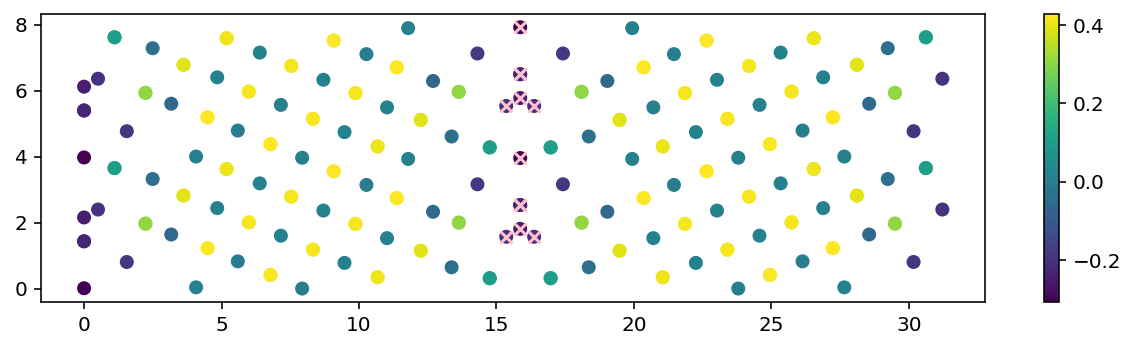

In [142]:
plt.figure(figsize=gb.cell.diagonal()[:2]/3)
plt.scatter(
    *x_output.T[:2],
    c=E_output,
)
plt.colorbar();
plt.scatter(*x_output[np.absolute(x_output[:,0]-0.5*gb.cell[0,0])<1, :2].T, marker='x', color='pink');

In [20]:
from scipy.spatial import cKDTree

In [21]:
x_tetra = get_x_input()[
    np.linalg.norm(x_output[:,None,:2]-get_x_input()[None,:,:2], axis=-1).min(axis=0).argmax()
]

In [22]:
tree = cKDTree(x_output)

In [23]:
xx = x_output[tree.query(x_tetra, k=3)[1]]
x_start = xx[0]
x_end = xx[2]

In [24]:
x = np.stack([x_start, x_end, x_tetra])

In [26]:
n_snapshots = 31
free_length = 7
lmp = pr.create.job.Lammps('drag')
lmp.structure = gb+pr.create.structure.atoms(
    elements=['H'], positions=[x_start], cell=gb.cell
)
lmp.potential = get_potential()
lmp.calc_minimize()
lmp.interactive_open()
for frac in tqdm(np.linspace(0, 1, n_snapshots)):
    if frac < 0.5:
        x = 2*frac*x_tetra+2*(0.5-frac)*x_start
    else:
        x = 2*(1-frac)*x_tetra+2*(frac-0.5)*x_end
    lmp.structure = gb.repeat([1, 4, 4])+pr.create.structure.atoms(
        elements=['H'], positions=[x], cell=gb.cell
    )
    lmp.structure.add_tag(selective_dynamics=3*[False])
    lmp.structure.selective_dynamics[lmp.structure.get_neighbors(
        num_neighbors=None, cutoff_radius=free_length
    ).ragged.indices[-1]] = 3*[True]
    lmp.run()
lmp.interactive_close()


  0%|          | 0/31 [00:00<?, ?it/s]/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/atomistics/structure/atoms.py:1896: UserWarning: You are adding structures with different cell shapes. Taking the cell and pbc of the first structure:Cell([[31.724640512383917, -3.1591373232017884e-15, 1.9425739728795707e-15], [-1.1894834988761758e-31, 31.724640509162437, 1.9425739726823117e-15], [-8.687454909361119e-16, -8.687454909361117e-16, 14.18769054948686]])
  warnings.warn("You are adding structures with different cell shapes. "
  3%|▎         | 1/31 [00:00<00:10,  2.92it/s]

The job drag was saved and received the ID: 15990664


100%|██████████| 31/31 [00:08<00:00,  3.75it/s]


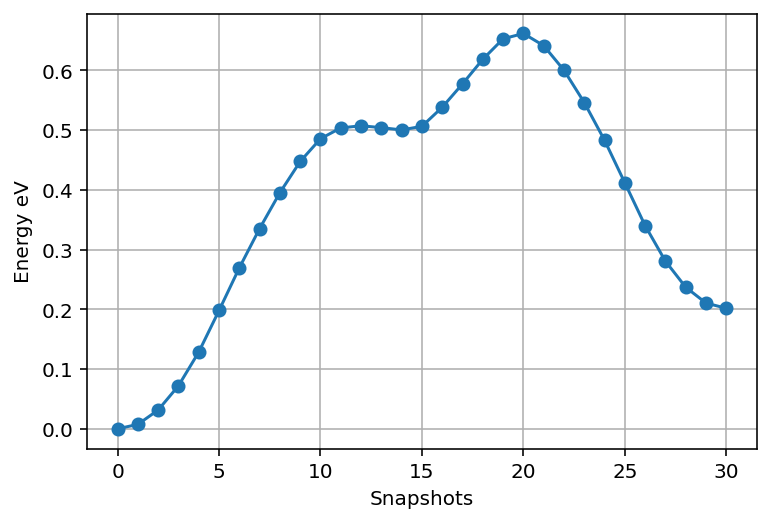

In [27]:
plt.ylabel('Energy eV')
plt.xlabel('Snapshots')
plt.grid()
plt.plot(lmp.output.energy_pot[::-1]-lmp.output.energy_pot.min(), '-o')

In [257]:
x = x_output[np.absolute(x_output[:,0]-0.5*gb.cell[0,0])<0.2]
tree = cKDTree(x)

In [258]:
distances, indices = tree.query(x, k=10)

conditions = distances[:,1:]/a_0*np.sqrt(2) < 1.2
indices = indices[:,1:]
indices = np.stack((np.indices(indices.shape)[0][conditions], indices[conditions]), axis=-1)
indices = np.sort(indices, axis=-1)
indices = np.unique(indices, axis=0)

In [272]:
x

array([[1.58623203e+01, 1.81036154e+00, 8.85251074e-16],
       [1.58623203e+01, 2.53269242e+00, 7.13802153e-01],
       [1.58623203e+01, 2.53269242e+00, 2.83312048e+00],
       [1.58623203e+01, 5.77594160e+00, 1.77346132e+00],
       [1.58623203e+01, 6.49827249e+00, 1.05965917e+00],
       [1.58623203e+01, 6.49827249e+00, 2.48726347e+00],
       [1.58623203e+01, 7.92233043e+00, 1.77346132e+00],
       [1.58623203e+01, 3.95675037e+00, 3.22055166e-17]])

In [273]:
x = x_output[np.absolute(x_output[:,0]-0.5*gb.cell[0,0])<0.2]
x = x[[3, 7]]
(gb+pr.create.structure.atoms(elements=len(x)*['H'], positions=x, cell=gb.cell)).plot3d()

NGLWidget()

In [274]:
E_art = []
lmp = pr.create.job.Lammps('art_lmp', delete_existing_job=True)
structure = gb.repeat([1, 4, 4])+pr.create.structure.atoms(
    elements=['H'], positions=[x[0]], cell=gb.cell
)
lmp.structure = structure.copy()
lmp.structure.positions[-1] = x[0]
lmp.potential = get_potential()
lmp.calc_minimize()
lmp.interactive_open()
lmp.run()
E_art.append(lmp.output.energy_pot[-1])
lmp.structure = structure.copy()
lmp.structure.positions[-1] = x[1]
lmp.run()
E_art.append(lmp.output.energy_pot[-1])
lmp.structure = structure.copy()
lmp.structure.positions[-1] = np.mean(x, axis=0)+np.array([0, 0, 0.01])
ART(lmp, lmp.structure.select_index('H').squeeze(), np.squeeze(np.diff(x, axis=0)))
lmp.run()
E_art.append(lmp.output.energy_pot[-1])
lmp.interactive_close()

E_art = np.array(E_art)
E_art -= E_art.min()

/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/atomistics/structure/atoms.py:1896: UserWarning:

You are adding structures with different cell shapes. Taking the cell and pbc of the first structure:Cell([[31.724640512383917, -3.1591373232017884e-15, 1.9425739728795707e-15], [-1.1894834988761758e-31, 31.724640509162437, 1.9425739726823117e-15], [-8.687454909361119e-16, -8.687454909361117e-16, 14.18769054948686]])



The job art_lmp was saved and received the ID: 15991338


In [275]:
n_snapshots = 31
free_length = 7
lmp = pr.create.job.Lammps('drag', delete_existing_job=True)
lmp.potential = get_potential()
lmp.calc_minimize()
lmp.interactive_open()
for frac in tqdm(np.linspace(0, 1, n_snapshots)):
    lmp.structure = structure.copy()
    lmp.structure.positions[-1] = x[0]*(1-frac)+x[1]*frac
    lmp.structure.add_tag(selective_dynamics=3*[False])
    lmp.structure.selective_dynamics[lmp.structure.get_neighbors(
        num_neighbors=None, cutoff_radius=free_length
    ).ragged.indices[-1]] = 3*[True]
    lmp.run()
lmp.interactive_close()



/u/samsstud/dev_sam/pyiron_atomistics/pyiron_atomistics/lammps/base.py:1299: UserWarning:

No structure set, can not validate the simulation cell!

  3%|▎         | 1/31 [00:00<00:09,  3.00it/s]

The job drag was saved and received the ID: 15991339


100%|██████████| 31/31 [00:08<00:00,  3.75it/s]


In [276]:
x_H = pr.load('art_lmp').output.positions[:,-1]

ratio = np.linalg.norm(x_H[:-1]-x_H[-1], axis=-1)
ratio /= np.sum(ratio)

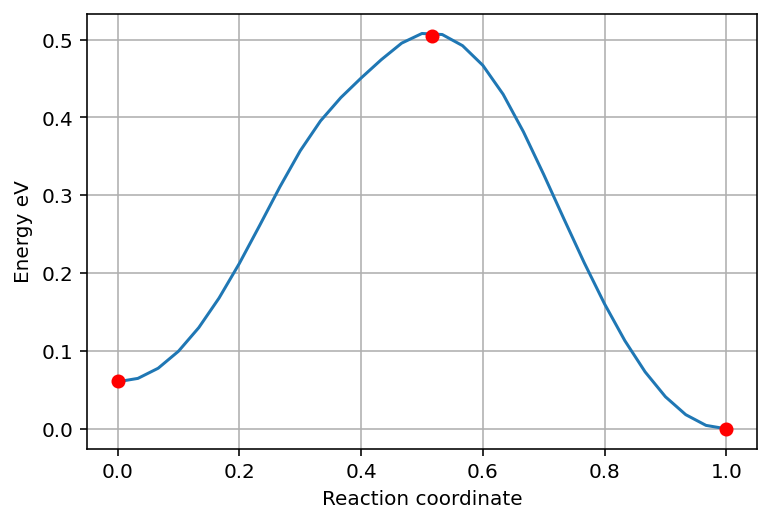

In [277]:
lmp = pr.load('drag')
plt.xlabel('Reaction coordinate')
plt.ylabel('Energy eV')
plt.plot(np.linspace(0, 1, n_snapshots), lmp.output.energy_pot-lmp.output.energy_pot.min())
plt.grid()
plt.plot([0, 1, ratio[0]], E_art, 'o', color='red')
# plt.axhline(E_max-E_start, color='blue')

In [249]:
(gb+pr.create.structure.atoms(positions=x_H, elements=['H', 'He', 'Li'], cell=gb.cell)).plot3d()

NGLWidget()